<h1>Forecasting</h1><h2 align="center">Training</h2>

In [17]:
from pandas import Series


def series_train_test_split(data: Series, trn_pct: float = 0.90) -> tuple[Series, Series]:
    trn_size: int = int(len(data) * trn_pct)
    df_cp: Series = data.copy()
    train: Series = df_cp.iloc[:trn_size, :]
    test: Series = df_cp.iloc[trn_size:]
    return train, test

In [18]:
from matplotlib.axes import Axes
from matplotlib.pyplot import subplots, savefig
from dslabs_functions import PAST_COLOR, FUTURE_COLOR, PRED_PAST_COLOR, PRED_FUTURE_COLOR, HEIGHT


def plot_forecasting_series(
    trn: Series,
    tst: Series,
    prd_tst: Series,
    title: str = "",
    xlabel: str = "time",
    ylabel: str = "",
) -> list[Axes]:
    fig, ax = subplots(1, 1, figsize=(4 * HEIGHT, HEIGHT), squeeze=True)
    fig.suptitle(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(trn.index, trn.values, label="train", color=PAST_COLOR)
    ax.plot(tst.index, tst.values, label="test", color=FUTURE_COLOR)
    ax.plot(prd_tst.index, prd_tst.values, "--", label="test prediction", color=PRED_FUTURE_COLOR)
    ax.legend(prop={"size": 5})

    return ax

In [19]:
from math import sqrt
from dslabs_functions import plot_multibar_chart, FORECAST_MEASURES


def plot_forecasting_eval(trn: Series, tst: Series, prd_trn: Series, prd_tst: Series, title: str = "") -> list[Axes]:
    ev1: dict = {
        "RMSE": [sqrt(FORECAST_MEASURES["MSE"](trn, prd_trn)), sqrt(FORECAST_MEASURES["MSE"](tst, prd_tst))],
        "MAE": [FORECAST_MEASURES["MAE"](trn, prd_trn), FORECAST_MEASURES["MAE"](tst, prd_tst)],
    }
    ev2: dict = {
        "MAPE": [FORECAST_MEASURES["MAPE"](trn, prd_trn), FORECAST_MEASURES["MAPE"](tst, prd_tst)],
        "R2": [FORECAST_MEASURES["R2"](trn, prd_trn), FORECAST_MEASURES["R2"](tst, prd_tst)],
    }

    # print(eval1, eval2)
    fig, axs = subplots(1, 2, figsize=(1.5 * HEIGHT, 0.75 * HEIGHT), squeeze=True)
    fig.suptitle(title)
    plot_multibar_chart(["train", "test"], ev1, ax=axs[0], title="Scale-dependent error", percentage=False)
    plot_multibar_chart(["train", "test"], ev2, ax=axs[1], title="Percentage error", percentage=True)
    return axs

<h2 align="center">Simple Average</h2>

In [20]:
from sklearn.base import RegressorMixin


class SimpleAvgRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.mean: float = 0.0
        return

    def fit(self, X: Series):
        self.mean = X.mean()
        return

    def predict(self, X: Series) -> Series:
        prd: list = len(X) * [self.mean]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

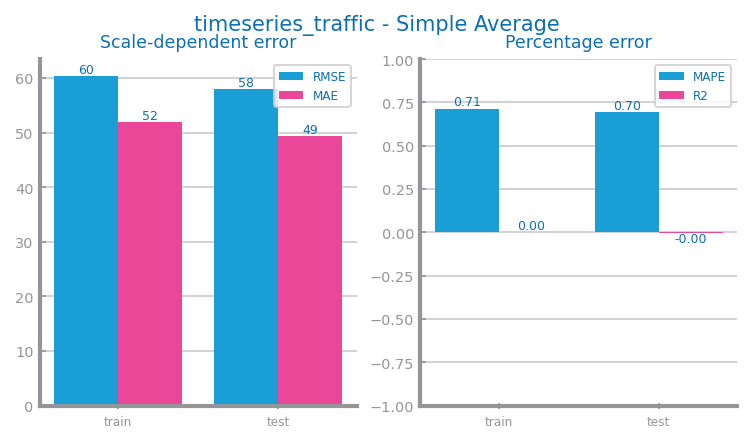

In [21]:
from pandas import read_csv, DataFrame, Series

file_tag = "timeseries_traffic"
target = "Total"
filename = "../../../data/forecast_traffic_single.csv"
timecol = "Timestamp"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
data = data.sort_values(['Timestamp'], ascending=True)
series: Series = data[target]

train, test = series_train_test_split(data, trn_pct=0.90)

fr_mod = SimpleAvgRegressor()
fr_mod.fit(train)
prd_trn: Series = fr_mod.predict(train)
prd_tst: Series = fr_mod.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Simple Average")
savefig(f"images/{file_tag}_simpleAvg_eval.png")

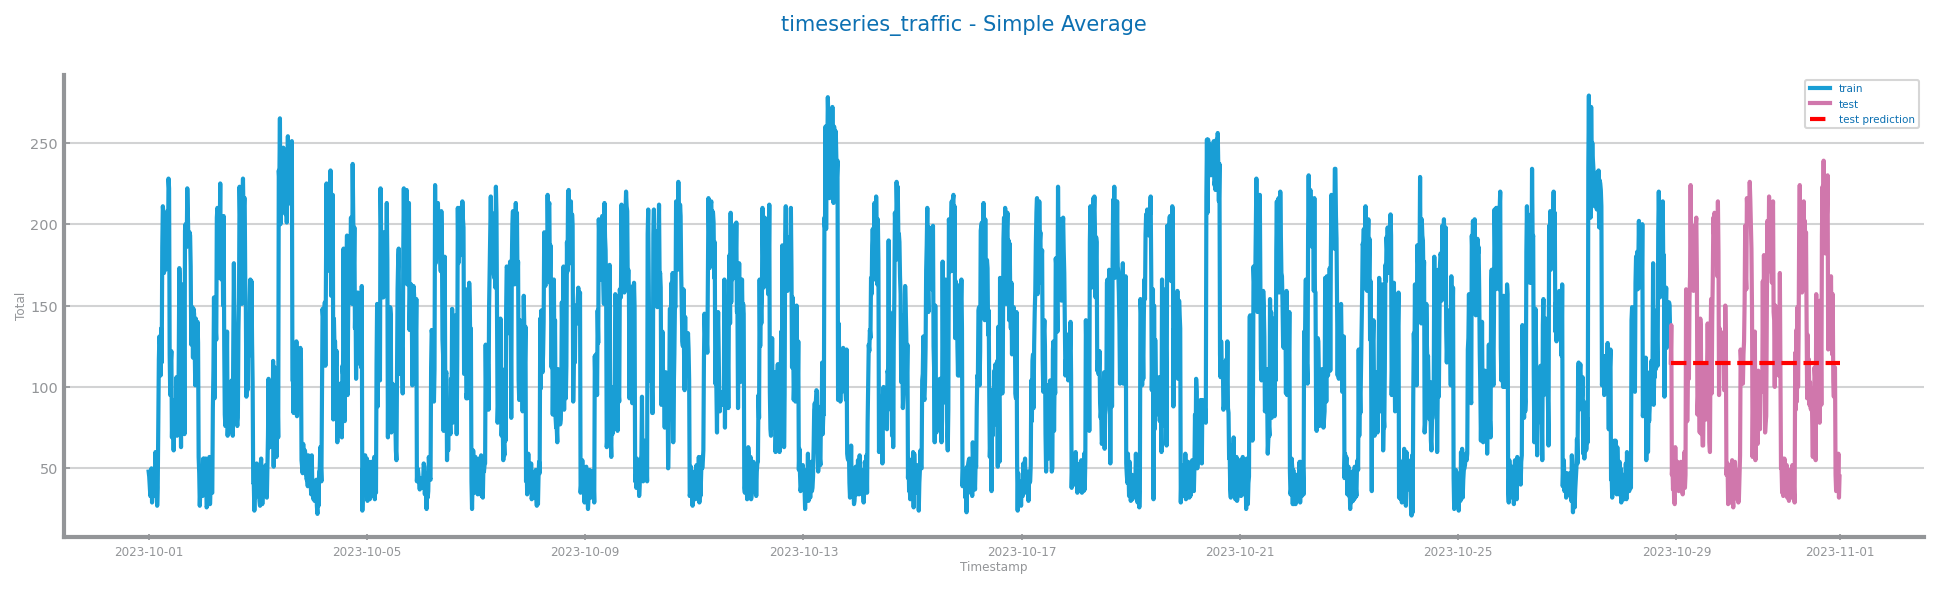

In [22]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Simple Average",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_simpleAvg_forecast.png")